In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime
from dateutil.relativedelta import relativedelta
import time

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import glob, os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import xskillscore as xs

from eofs.xarray import Eof
from eofs.standard import Eof as sEof # If needed
from eofs.multivariate.standard import MultivariateEof

from scipy import stats
import statsmodels.api as sm

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()

# input the hindcast file name.

In [18]:
#fname = 'sic_sst_sat_2*1*1_20'
#sic_sst_sat_sthf_2*1*1*0.5_12
#fname = 'sic_sat_z_u_v-2*1*1*1*1-9'
fname = 'sic_sst_sat_sthf-2*1*1*1-9'

# READ the file here.
filename = '/d6/bxw2101/model_files/hcast_output/' + fname + '.nc'
sic_hcast_ds = xr.open_dataset(filename)
sic_hcast = sic_hcast_ds.__xarray_dataarray_variable__

filename = '/d6/bxw2101/model_files/cross_output/' + fname + '.nc'
sic_cross_ds = xr.open_dataset(filename)
sic_cross = sic_cross_ds.__xarray_dataarray_variable__

# SIC: 1x0.5
filename = '/d6/bxw2101/model_files/datasets/sic_1x0p5.nc'
sic_anom_ds = xr.open_dataset(filename)
sic_anom = sic_anom_ds.sic_anom_smoothed
sic_obs = sic_anom.isel(tdim=slice(12, 516))

In [19]:
dateofinterest = '1992-07-01'

## Looking at hindcasts for a specific MONTH, initial plots to make sure our hindcast code works

Text(0.5, 0.98, 'Hindcast for 1992-07-01')

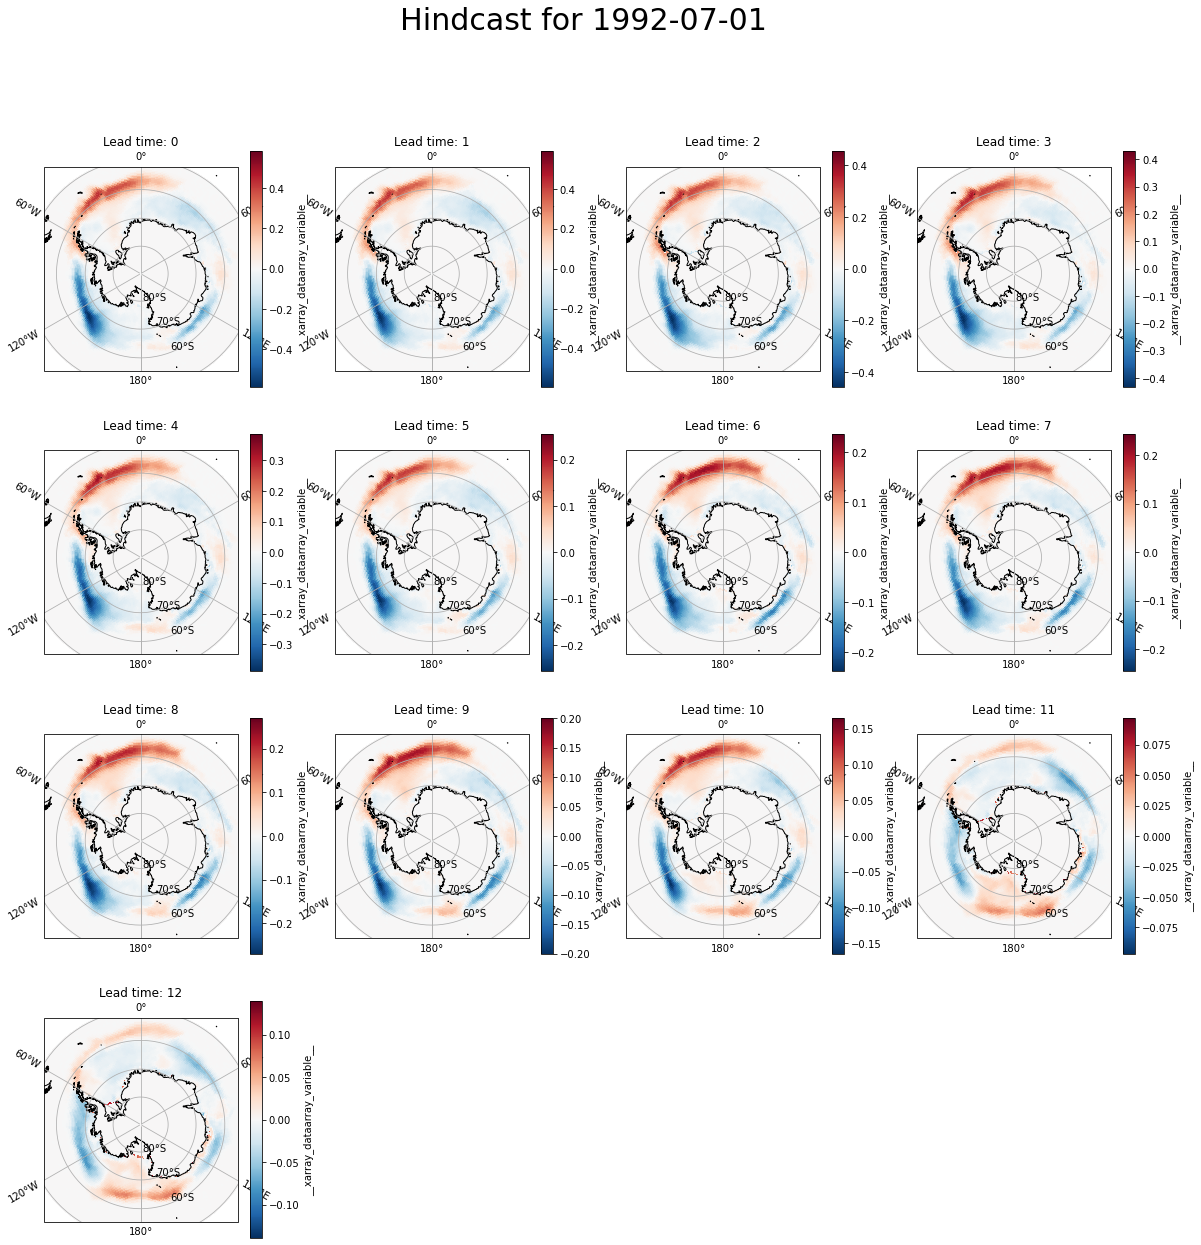

In [4]:
# Display hindcasts of a certain month, with lead time from 0 to 12.
fig = plt.figure(figsize=(20,20))
for lead in range(0, 13):
    arb_hcast = sic_hcast.sel(tdim=dateofinterest).sel(lead=lead)
    ax = plt.subplot(4, 4, lead + 1, projection=sp)
    im = arb_hcast.plot(transform=pc)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('Lead time: ' + str(lead))

plt.suptitle('Hindcast for ' + dateofinterest, fontsize=30)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)
# plt.show()

Text(0.5, 1.0, 'Actual anomaly')

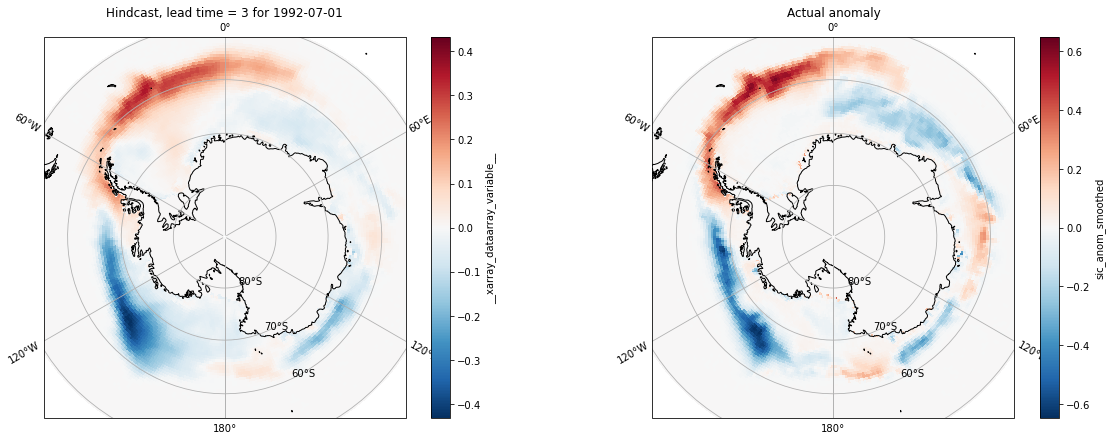

In [5]:
# hindcast w/ lead time = j
j = 3
arb_hcast = sic_hcast.sel(tdim=dateofinterest).sel(lead=j)
fig = plt.figure(figsize=(20,7))
ax = plt.subplot(1, 2, 1, projection=sp)
im = arb_hcast.plot(transform=pc)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
ax.set_title(f'Hindcast, lead time = {j} for {dateofinterest}')

# the ACTUAL anomaly:
ax = plt.subplot(1, 2, 2, projection=sp)
sic_anom.sel(tdim=dateofinterest).plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
#arb_time.plot(transform=pc)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
ax.set_title('Actual anomaly')

## comparing my results w david's here: His testing data is May 2013 - Dec 2021.

In [44]:
testing_set = sic_anom.isel(tdim=slice(412, 504))
testing_set_cross = sic_cross.isel(tdim=slice(400, 504))

In [58]:
corrs = np.zeros([4, 92])
rmses = np.zeros([4, 92])
# 4 rows, leadtimes 1, 3, 6, 9. each has 92 months.

leadtimes = [1, 3, 6, 9]
for i in range(92):
    for j in range(4):
        leadtime = leadtimes[j]
        testing_set[i].values.flatten(),
        corrs[j][i] = np.corrcoef(testing_set[i].values.flatten(), testing_set_cross[i].sel(lead=leadtime).values.flatten())[0, 1]
        rmses[j][i] = xs.rmse(testing_set[i], testing_set_cross[i].sel(lead=leadtime)).data

print('2013-05-01 to 2020-12-01, Linear Markov Model corr and rmse. To be compared w/ David')
for i in range(4):
    print(f'Avg corr for lead = {leadtimes[i]}: {corrs[i].mean()}')
    print(f'Avg rmse for lead = {leadtimes[i]}: {rmses[i].mean()}\n')

2013-05-01 to 2020-12-01, Linear Markov Model corr and rmse. To be compared w/ David
Avg corr for lead = 1: 0.5690856744694149
Avg rmse for lead = 1: 0.049657923564439634

Avg corr for lead = 3: 0.3410293559998514
Avg rmse for lead = 3: 0.059117281759093844

Avg corr for lead = 6: 0.14474235138298316
Avg rmse for lead = 6: 0.06465880060559609

Avg corr for lead = 9: 0.09456148894656648
Avg rmse for lead = 9: 0.06444368191958379



## Looking at hindcasts of a specific season (set of three months)

In [6]:
szn_center = '1992-07-01'
szn_end = datetime.datetime.strftime(datetime.datetime.strptime(szn_center, '%Y-%m-%d') + relativedelta(months=1), '%Y-%m-%d')
szn_bgn = datetime.datetime.strftime(datetime.datetime.strptime(szn_center, '%Y-%m-%d') + relativedelta(months=-1), '%Y-%m-%d')

szn_hcast = (sic_hcast.sel(tdim=szn_bgn) + sic_hcast.sel(tdim=szn_center) + sic_hcast.sel(tdim=szn_end))/3
szn_anom = (sic_anom.sel(tdim=szn_center)+ sic_anom.sel(tdim=szn_bgn) + sic_anom.sel(tdim=szn_end)) / 3

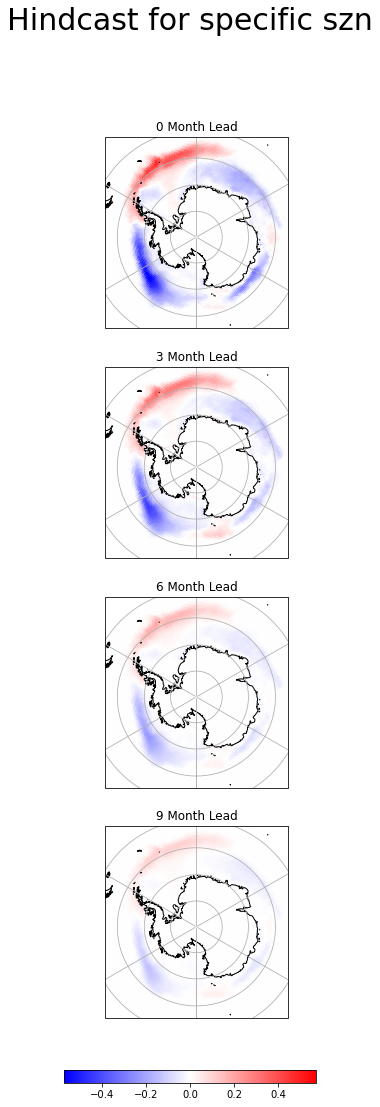

In [7]:
plot_leads = [0, 3, 6, 9]
fig = plt.figure(figsize=(7,18))
sic_max = szn_hcast.max()
sic_min = szn_hcast.min()
cmap_lim = max(szn_hcast.max(), abs(szn_hcast.min()))
for i in range(len(plot_leads)):
    ax = plt.subplot(4, 1, i + 1, projection=sp) 
    im = szn_hcast.sel(lead=plot_leads[i]).plot(transform=pc, vmin = -cmap_lim, vmax = cmap_lim, cmap = 'bwr', add_colorbar = False) 
    #im = szn_hcast.sel(lead=plot_leads[i]).plot(transform=pc, vmin = -0.3, vmax = 0.3, cmap = 'bwr', add_colorbar = False) 
    
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title(str(plot_leads[i]) + ' Month Lead')

plt.suptitle('Hindcast for specific szn', fontsize=30)
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.01]) # I'm ngl idk how tf this works
cbar = fig.colorbar(im, cax = cbar_ax, orientation = 'horizontal')

Text(0.5, 1.0, 'actual anomaly in JJA 1992 just fyi')

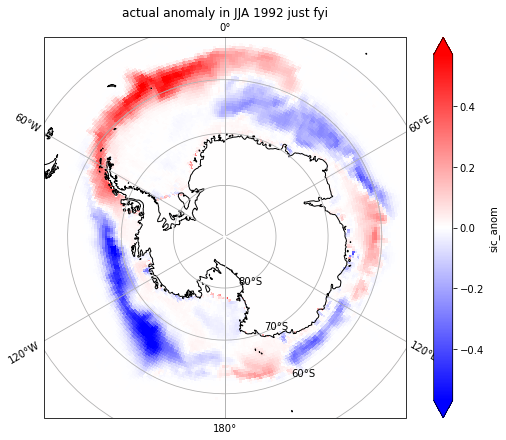

In [8]:
# the actual JJA 1992 anomaly:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
jja1992_anom = (sic_anom.sel(tdim='1992-08-01')+ sic_anom.sel(tdim='1992-07-01') + sic_anom.sel(tdim='1992-06-01')) / 3
jja1992_anom.plot(transform=pc,  cmap = 'bwr', vmin = -cmap_lim, vmax = cmap_lim) 
#sic_obsr.sel(tdim='1992-07-01').plot(transform=pc)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
ax.set_title('actual anomaly in JJA 1992 just fyi')

## Correlation maps

In [6]:
# Colormap we define.
cmap_corrs = colors.ListedColormap(['white','#EAEAEA','#D6EAF8',
                                    '#85C1E9','#F4CAFE','#FE90F7',
                                    '#FC6CB2','#FE2D2D','#D80606',
                                    '#A50000'])

Text(0.5, 0.98, 'Hindcast/Observation Correlation (1980-2021)\nsic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11')

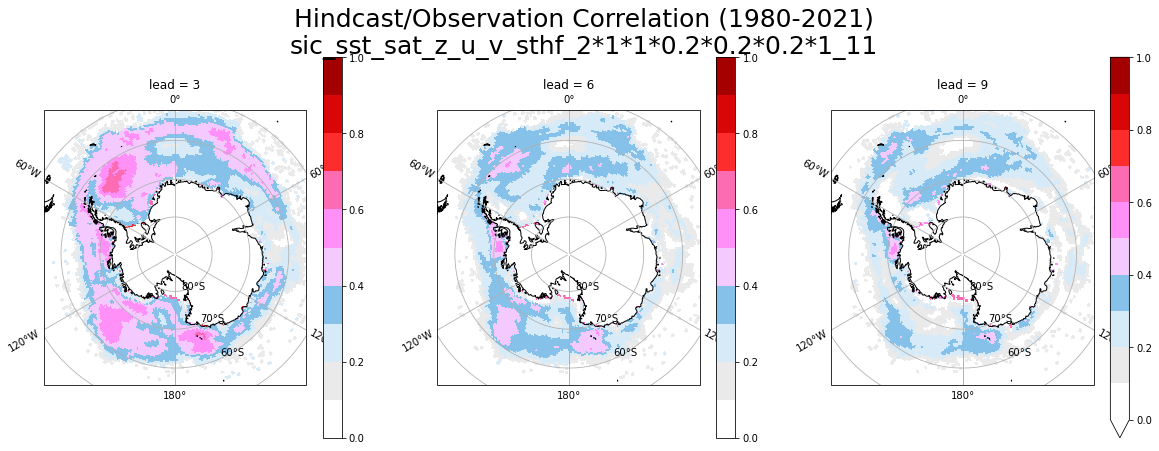

In [7]:
# Correlation maps w/ given lead time: across ALL seasons.
#using a specific number of modes:
leads = [3, 6, 9]
fig = plt.figure(figsize=(20,7))
for i in range(len(leads)):
    corrs_da = xr.corr(sic_obs, sic_hcast.sel(lead=leads[i]), dim='tdim')
    pvals_da = xs.pearson_r_eff_p_value(sic_obs, sic_hcast.sel(lead=leads[i]), dim='tdim', skipna=True)
    sig_corrs_da = corrs_da.where(pvals_da < 0.05)
    ax = plt.subplot(1, 3, i + 1, projection=sp) 
    im = sig_corrs_da.plot(transform=pc, cmap = cmap_corrs, vmin = 0, vmax=1)
    #sic_obsr.sel(tdim='2017-12-01').plot(transform=pc)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.suptitle('Hindcast/Observation Correlation (1980-2021)\n' + fname, fontsize=25)

Text(0.5, 0.98, 'Hindcast/Observation Correlation (1980-2021)\nsic_sst_sat_2*1*1_20')

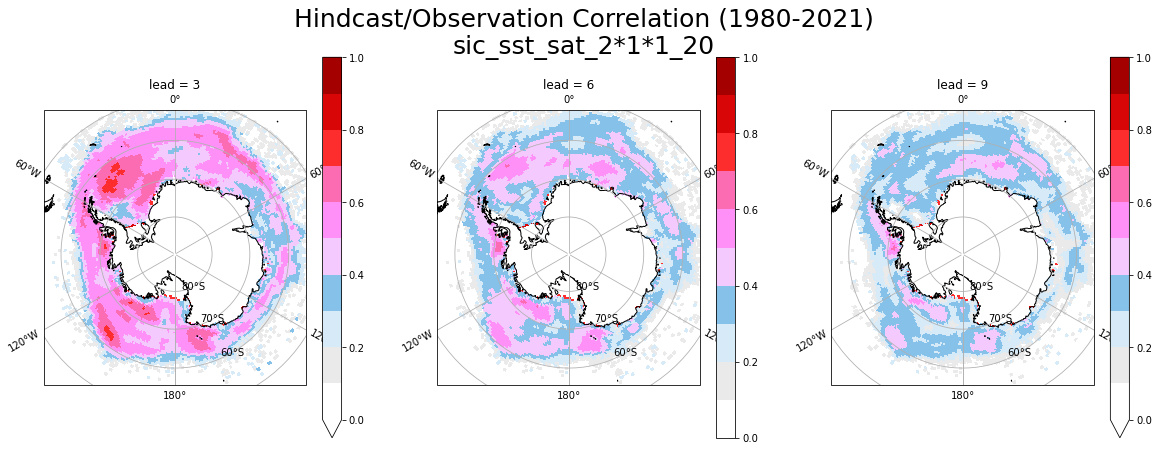

In [23]:
# Correlation maps w/ given lead time: across ALL seasons.
#using a specific number of modes:
leads = [3, 6, 9]
fig = plt.figure(figsize=(20,7))
for i in range(len(leads)):
    corrs_da = xr.corr(sic_obs, sic_hcast.sel(lead=leads[i]), dim='tdim')
    pvals_da = xs.pearson_r_eff_p_value(sic_obs, sic_hcast.sel(lead=leads[i]), dim='tdim', skipna=True)
    sig_corrs_da = corrs_da.where(pvals_da < 0.05)
    ax = plt.subplot(1, 3, i + 1, projection=sp) 
    im = sig_corrs_da.plot(transform=pc, cmap = cmap_corrs, vmin = 0, vmax=1)
    #sic_obsr.sel(tdim='2017-12-01').plot(transform=pc)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.suptitle('Hindcast/Observation Correlation (1980-2021)\n' + fname, fontsize=25)

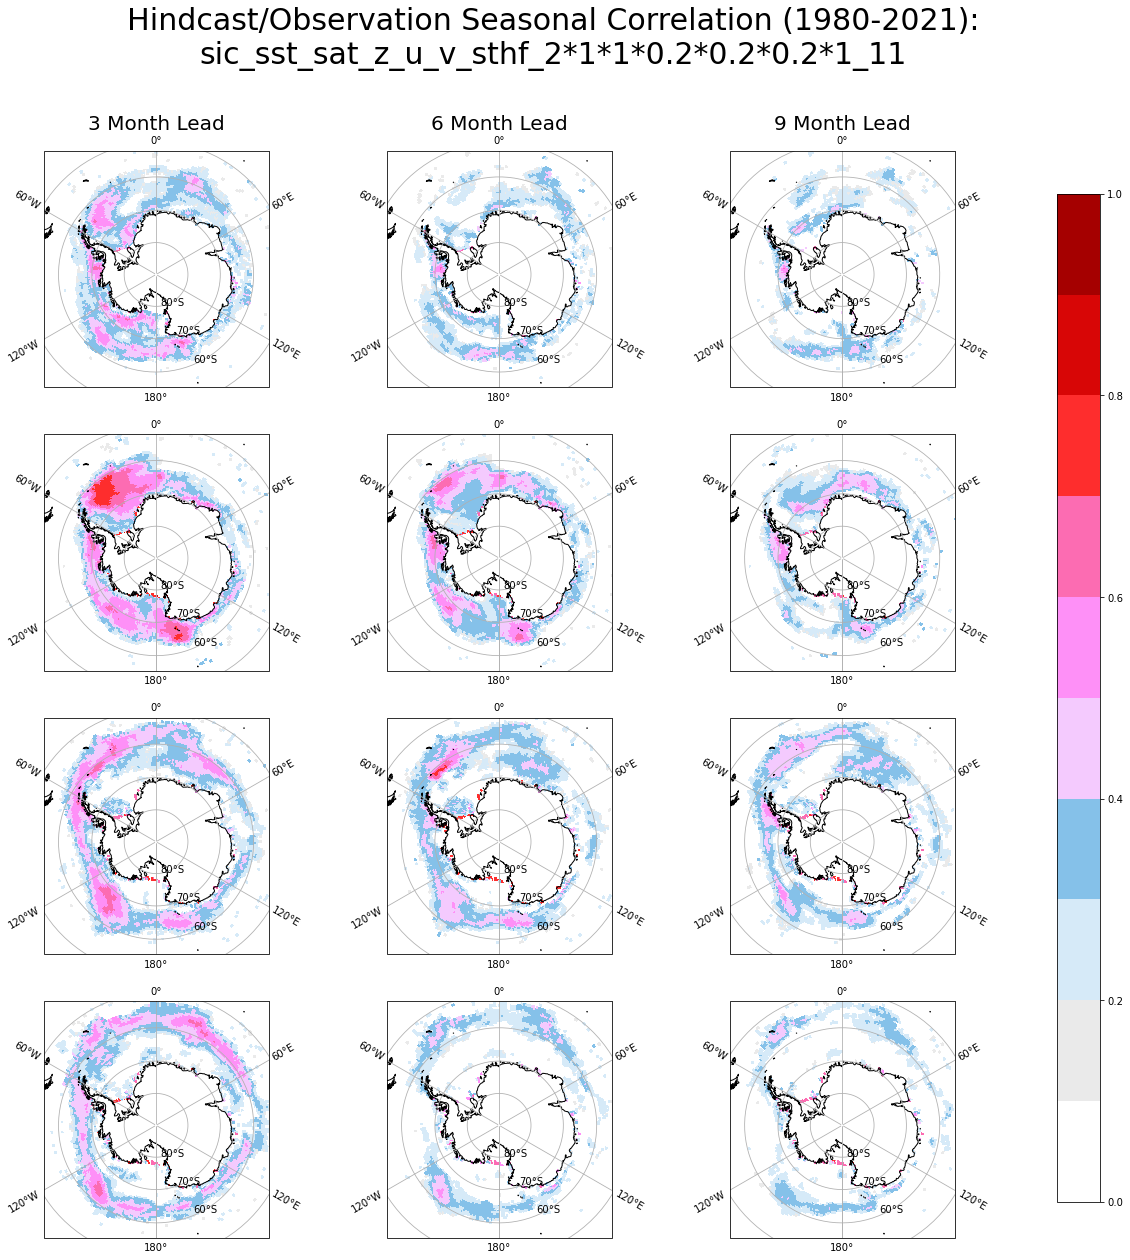

In [8]:
# Correlation maps w/ given lead time: seasonal
seasons = ["DJF", "MAM", "JJA", "SON"] # <- here are the categories.
leads = [3, 6, 9]

fig = plt.figure(figsize=(20, 20))
for s_i in range(len(seasons)):
    season = seasons[s_i]
    for i in range(len(leads)):
        ax = plt.subplot(4, 3, (s_i * 3) + i + 1, projection=sp) 
        corrs_da = xr.corr(sic_obs.sel(tdim=sic_obs.tdim.dt.season==season),
                       sic_hcast.sel(tdim=sic_hcast.tdim.dt.season==season).sel(lead=leads[i]),
                       dim='tdim')
        # eff p-value? or just p-value?
        pvals_da = xs.pearson_r_eff_p_value(sic_obs.sel(tdim=sic_obs.tdim.dt.season==season),
                                            sic_hcast.sel(tdim=sic_hcast.tdim.dt.season==season).sel(lead=leads[i]),
                                            dim='tdim', skipna=True)
        sig_corrs_da = corrs_da.where(pvals_da < 0.05)
        im = sig_corrs_da.plot(transform=pc, cmap = cmap_corrs,vmin = 0, vmax=1, add_colorbar=False,)
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
        
        if s_i == 0:
            ax.set_title(str(leads[i]) +' Month Lead', fontsize=20)
        else:
            ax.set_title('')

plt.suptitle('Hindcast/Observation Seasonal Correlation (1980-2021):\n' + fname, fontsize=30);
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax = cbar_ax)

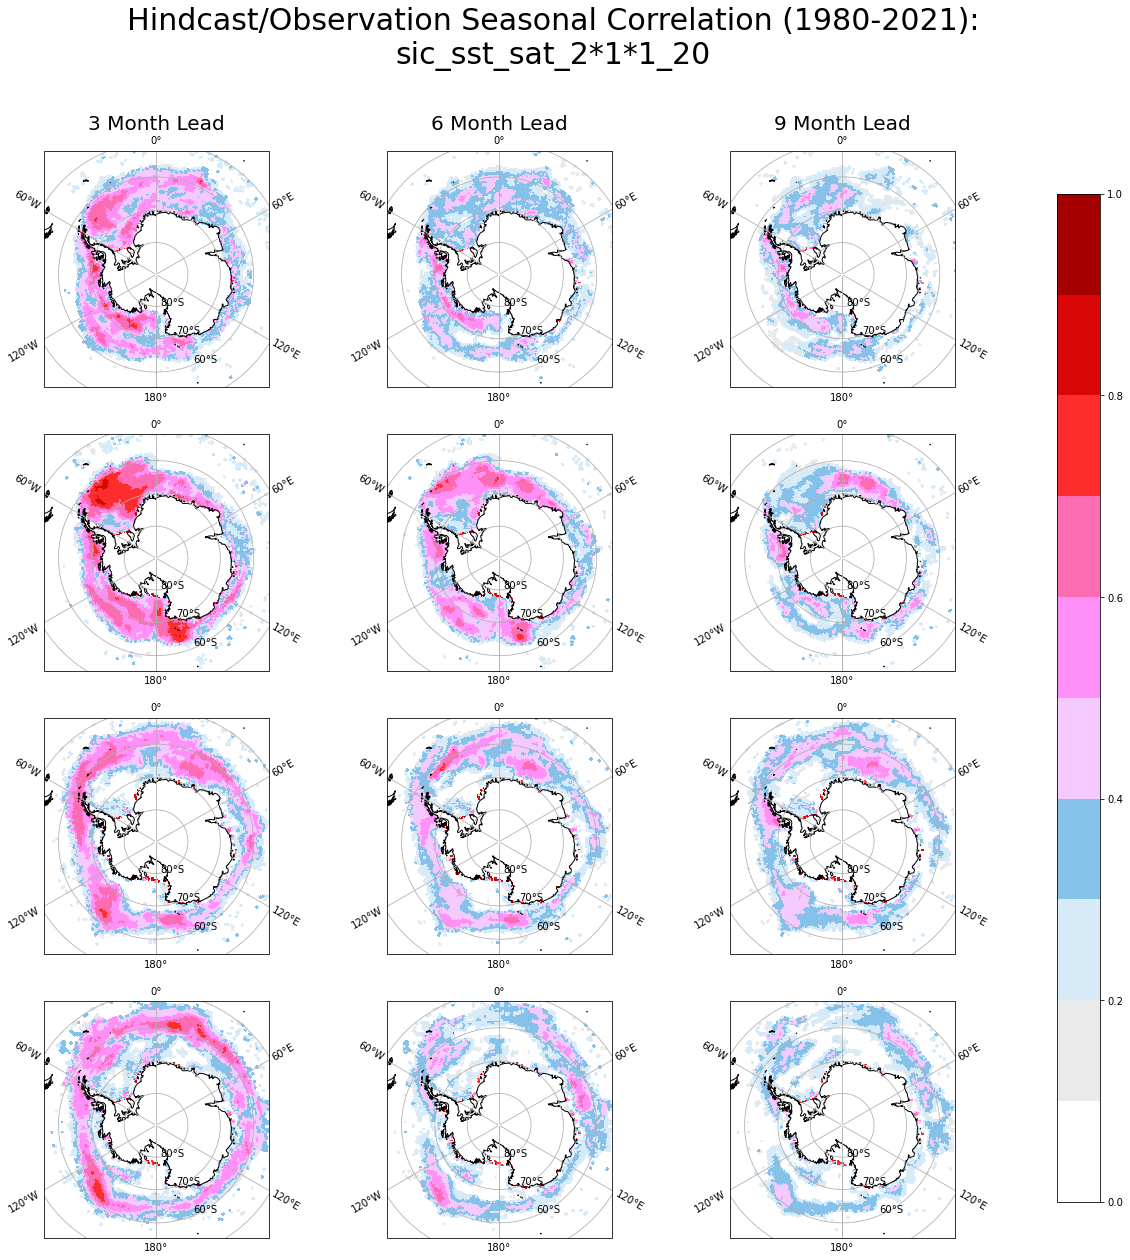

In [72]:
# Correlation maps w/ given lead time: seasonal
seasons = ["DJF", "MAM", "JJA", "SON"] # <- here are the categories.
leads = [3, 6, 9]

fig = plt.figure(figsize=(20, 20))
for s_i in range(len(seasons)):
    season = seasons[s_i]
    for i in range(len(leads)):
        ax = plt.subplot(4, 3, (s_i * 3) + i + 1, projection=sp) 
        corrs_da = xr.corr(sic_obs.sel(tdim=sic_obs.tdim.dt.season==season),
                       sic_hcast.sel(tdim=sic_hcast.tdim.dt.season==season).sel(lead=leads[i]),
                       dim='tdim')
        # eff p-value? or just p-value?
        pvals_da = xs.pearson_r_eff_p_value(sic_obs.sel(tdim=sic_obs.tdim.dt.season==season),
                                            sic_hcast.sel(tdim=sic_hcast.tdim.dt.season==season).sel(lead=leads[i]),
                                            dim='tdim', skipna=True)
        sig_corrs_da = corrs_da.where(pvals_da < 0.05)
        im = sig_corrs_da.plot(transform=pc, cmap = cmap_corrs,vmin = 0, vmax=1, add_colorbar=False,)
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
        
        if s_i == 0:
            ax.set_title(str(leads[i]) +' Month Lead', fontsize=20)
        else:
            ax.set_title('')

plt.suptitle('Hindcast/Observation Seasonal Correlation (1980-2021):\n' + fname, fontsize=30);
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax = cbar_ax)

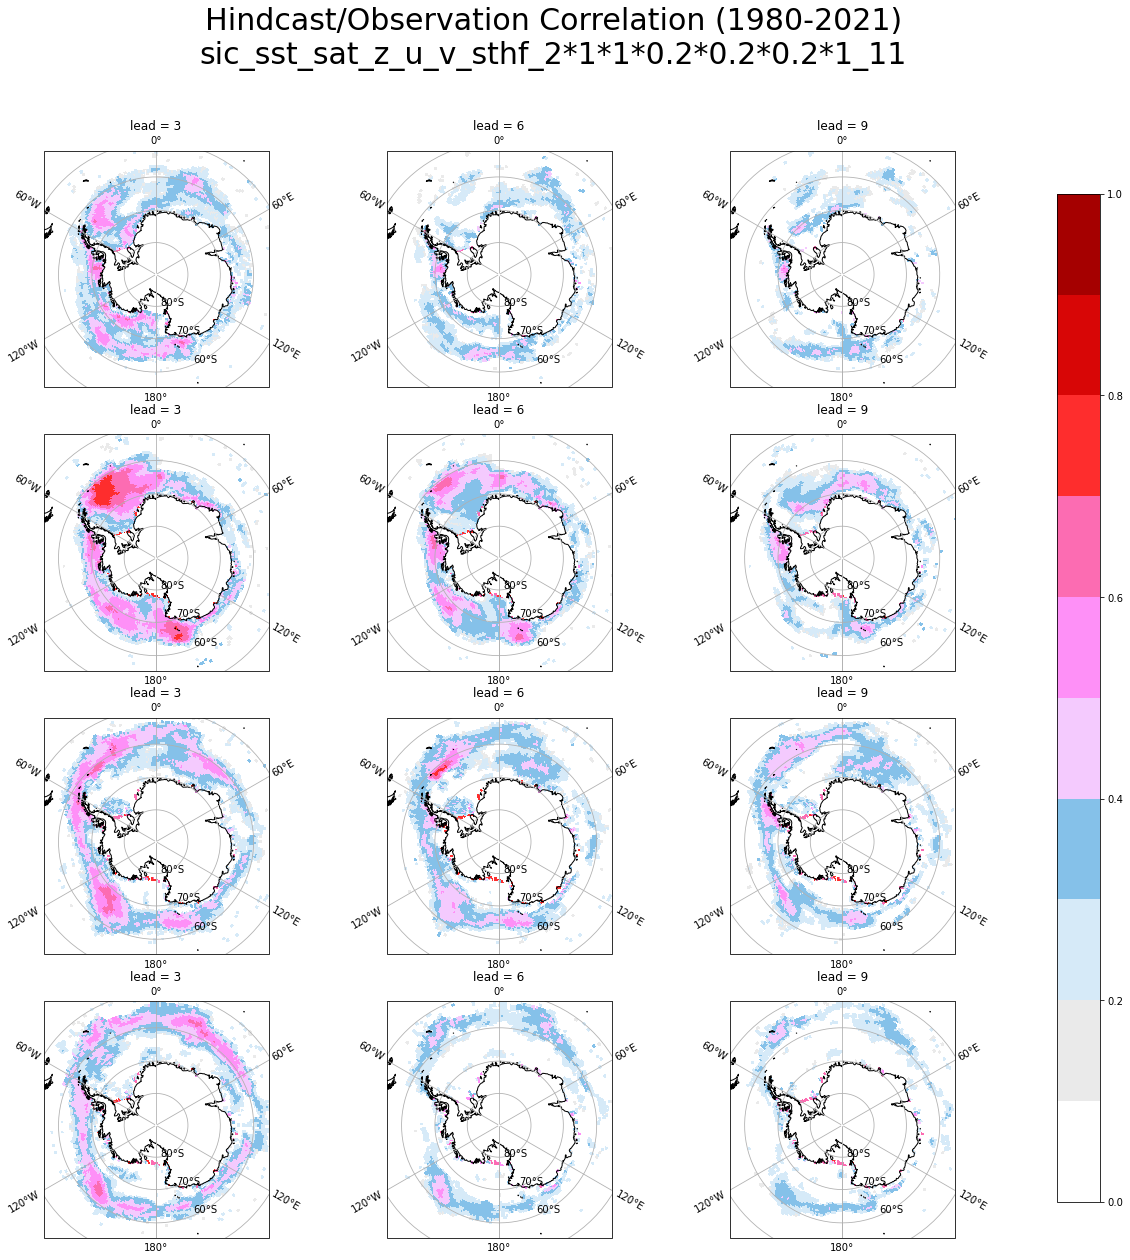

In [77]:
# Correlation maps w/ given lead time: seasonal
seasons = ["DJF", "MAM", "JJA", "SON"] # <- here are the categories.
leads = [3, 6, 9]

fig = plt.figure(figsize=(20, 20))
for s_i in range(len(seasons)):
    season = seasons[s_i]
    for i in range(len(leads)):
        ax = plt.subplot(4, 3, (s_i * 3) + i + 1, projection=sp) 
        corrs_da = xr.corr(sic_obs.sel(tdim=sic_obs.tdim.dt.season==season),
                       sic_hcast.sel(tdim=sic_hcast.tdim.dt.season==season).sel(lead=leads[i]),
                       dim='tdim')
        # eff p-value? or just p-value?
        pvals_da = xs.pearson_r_eff_p_value(sic_obs.sel(tdim=sic_obs.tdim.dt.season==season),
                                            sic_hcast.sel(tdim=sic_hcast.tdim.dt.season==season).sel(lead=leads[i]),
                                            dim='tdim', skipna=True)
        sig_corrs_da = corrs_da.where(pvals_da < 0.05)
        im = sig_corrs_da.plot(transform=pc, cmap = cmap_corrs, vmin = 0, vmax=1, add_colorbar=False)
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    

plt.suptitle('Hindcast/Observation Correlation (1980-2021)\n' + fname, fontsize=30)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax = cbar_ax)

In [ ]:
## New cross validation files analysis?? with the lead time plots...

In [ ]:
#HMM. comparing cross validation here.


sic_cross =xr.open_dataset('/d6/bxw2101/model_files/cross_output/sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc').__xarray_dataarray_variable__
szn_cross = (sic_cross.sel(tdim=szn_bgn) + sic_cross.sel(tdim=szn_center) + sic_cross.sel(tdim=szn_end))/3

fig = plt.figure(figsize=(18,7))

plot_leads = [3, 6, 9]
sic_max = szn_cross.max()
sic_min = szn_cross.min()
cmap_lim = max(sic_max, abs(sic_min))
print(cmap_lim)

ax = plt.subplot(1, 4, 1, projection=sp) 
#im = szn_anom.plot(transform=pc, vmin = -cmap_lim, vmax = cmap_lim, cmap = 'bwr', add_colorbar = False) 
im = szn_anom.plot(transform=pc, vmin = -0.3, vmax = 0.3, cmap = 'bwr', add_colorbar = False) 
ax.coastlines()
ax.gridlines(draw_labels=False)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
ax.set_title('Observed Anomaly', fontsize=20)

for i in range(len(plot_leads)):
    ax = plt.subplot(1, 4, i + 2, projection=sp) 
    #im = szn_cross.sel(lead=plot_leads[i]).plot(transform=pc, vmin = -cmap_lim, vmax = cmap_lim, cmap = 'bwr', add_colorbar = False) 
    im = szn_cross.sel(lead=plot_leads[i]).plot(transform=pc, vmin = -0.3, vmax = 0.3, cmap = 'bwr', add_colorbar = False) 
    
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title(str(plot_leads[i]) + ' Month Lead', fontsize=20)

#plt.suptitle('Cross Validated experiment anomaly for JJA 1992)', fontsize=30)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.3, 0.01, 0.4])
cbar = fig.colorbar(im, cax = cbar_ax)
cbar.ax.tick_params(labelsize=13) 